In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import time
import pickle
import os
#import matplotlib.pyplot as plt
from  data.pathsandmore import pathname
from functions import viz_per_time_period
from matplotlib import pyplot as plt

DATA_LOCATION='https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data'

crashes=pd.read_csv(pathname,dtype={'ZIP CODE': str},
                    low_memory=False,
                   parse_dates=["crash_date"],
                   date_format="ISO8601")
#fixing columns names
crashes.columns=[col.replace(' ','_').lower() for col in crashes.columns]
#checking time
max_hour=max([int(x.split(':')[0]) for x in crashes.crash_time])
min_hour=min([int(x.split(':')[0]) for x in crashes.crash_time])
print(f"the latest hour is {max_hour} and the earliest one is {min_hour}")
crashes['hour']=[int(x.split(':')[0]) for x in crashes.crash_time]
max_minute=max([int(x.split(':')[1]) for x in crashes.crash_time])
min_minute=min([int(x.split(':')[1]) for x in crashes.crash_time])
print(f"the latest hour is {max_minute} and the earliest one is {min_minute}")
crashes['weekday']=crashes.crash_date.dt.day_name()
crashes['weekday']=[day[:3] for day in crashes.weekday]
crashes['month']=crashes.crash_date.dt.month_name()
crashes['month']=[month[:3] for month in crashes.month]
crashes['year']=crashes['crash_date'].dt.year
print(f"The first day of this dataset is {crashes.crash_date.min()}")
print(f"The last day of this dataset is {crashes.crash_date.max()}")
##making it up to end of year 2023
crashes=crashes[(crashes.crash_date>'2012-12-31') &(crashes.crash_date<'2025-01-01')]
crashes.to_csv('./data/crashesupto2024.csv',index=False)

the latest hour is 23 and the earliest one is 0
the latest hour is 59 and the earliest one is 0
The first day of this dataset is 2012-07-01 00:00:00
The last day of this dataset is 2024-12-31 00:00:00


In [2]:
nulls_in_boroughs=crashes[(crashes.borough.isnull()) & (crashes.latitude.notnull())].shape[0]
print(f"These are the number of nulls in borough but that I have lat and long: {nulls_in_boroughs}")

These are the number of nulls in borough but that I have lat and long: 153902


In [3]:
crashes.isnull().sum()

crash_date                             0
crash_time                             0
borough                           340812
zip_code                          341074
latitude                          224455
longitude                         224455
location                          224353
on_street_name                    446368
cross_street_name                 806350
off_street_name                  1677954
number_of_persons_injured             18
number_of_persons_killed              31
number_of_pedestrians_injured          0
number_of_pedestrians_killed           0
number_of_cyclist_injured              0
number_of_cyclist_killed               0
number_of_motorist_injured             0
number_of_motorist_killed              0
contributing_factor_vehicle_1       7297
contributing_factor_vehicle_2     327813
contributing_factor_vehicle_3    1898225
contributing_factor_vehicle_4    2012283
contributing_factor_vehicle_5    2036811
collision_id                           0
vehicle_type_cod

<a id="top"></a>
## Temporal Analysis
> the following cells will go over the analysis of the crashes in NYC by different temporal periods.
1. [Year.](#year)
2. [Months.](#months)
3. [Weekdays.](#weekdays)
4. [Hours.](#hours)
5. [Weekend.](#weekend)

<a id="year"></a>

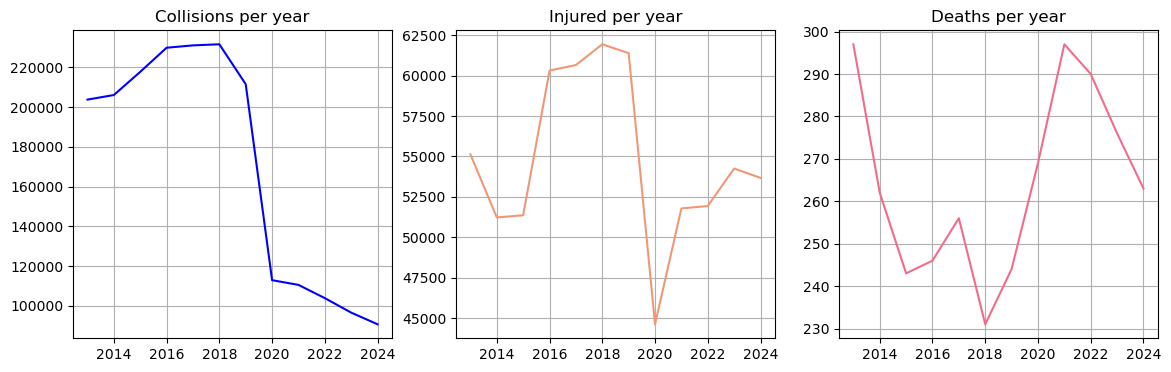

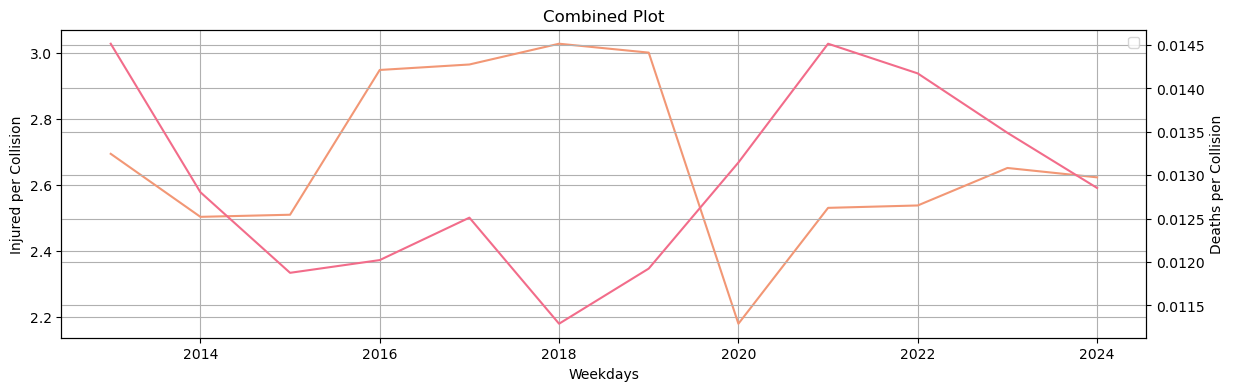

In [3]:
min_=min(crashes.year)
max_=max(crashes.year)
years_list=list(range(min_,max_+1))
viz_per_time_period(crashes, 'year', years_list)

> While the number of collisions and injured when down during 2020 (pandemic effect) it did not happen the same with the deaths.

> It is interesting to see how injured per collision and deaths per collision seem to follow opposite correlation.

In [4]:
 year_groupby=crashes.groupby('year')[['collision_id','number_of_persons_injured','number_of_persons_killed']].\
                        agg({'collision_id':'count',
                             'number_of_persons_injured':'sum',
                             'number_of_persons_killed':'sum'
                             
                                                                        }).reindex(years_list)
year_by_collision=(year_groupby*(100/crashes.shape[0])).iloc[:,1:]
year_by_collision.corr()
##Pretty surprising

,number_of_persons_injured,number_of_persons_killed
number_of_persons_injured,1.000000,-0.511207
number_of_persons_killed,-0.511207,1.000000


<a id="months"></a>

In [5]:
##Correlation is way higher since 2017
year2017on=crashes[crashes.year>=2017].groupby('year')[['collision_id','number_of_persons_injured','number_of_persons_killed']].\
                        agg({'collision_id':'count',
                             'number_of_persons_injured':'sum',
                             'number_of_persons_killed':'sum'
                             
                                                                        }).reindex(years_list)
                                                                        
year_by_collision=(year2017on*(100/crashes[crashes.year>=2017].shape[0])).iloc[:,1:]
year_by_collision.corr()

,number_of_persons_injured,number_of_persons_killed
number_of_persons_injured,1.000000,-0.695073
number_of_persons_killed,-0.695073,1.000000


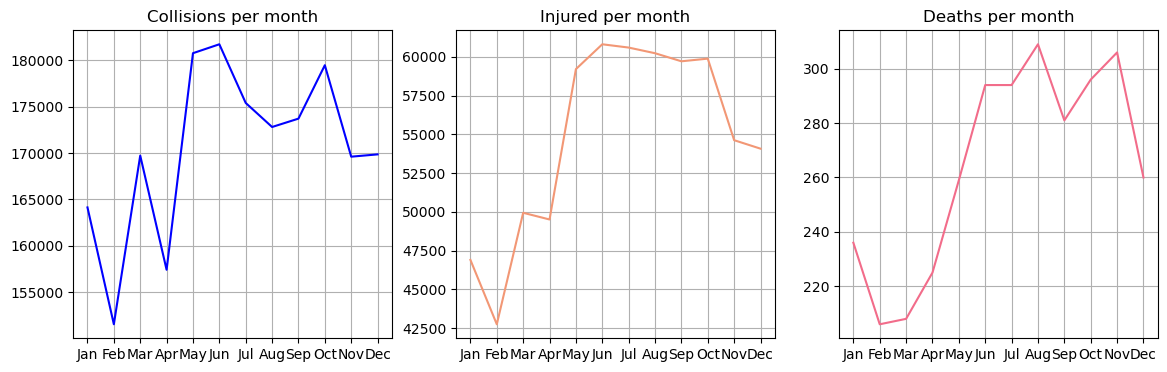

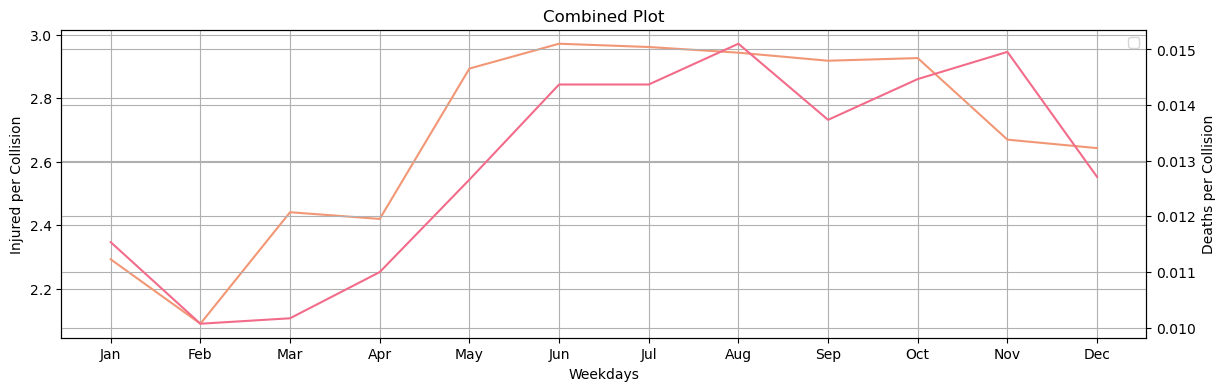

In [6]:
months_list=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep',\
            'Oct','Nov','Dec']
viz_per_time_period(crashes, 'month', months_list)

> Interesting insight: collisions and injuries peak in June, but the highest number of deaths occurs in November.

> Analysis per collision. Both graphs navigate together, with a significant gap in November, once again.

<a id="weekdays"></a>

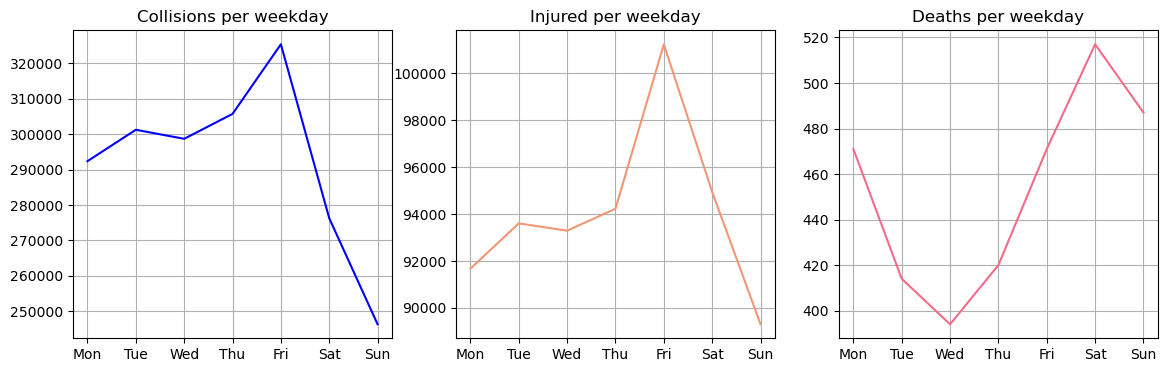

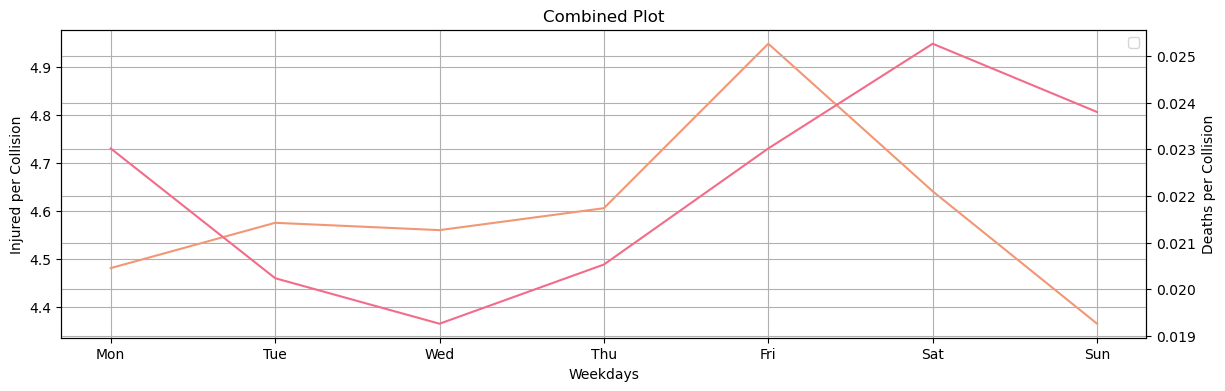

In [7]:
weekdays_list=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
viz_per_time_period(crashes, 'weekday', weekdays_list)

> While the number of deaths have their peak during the weekends it is during the weekdays when most collisions happen.

> Although the higher numbers for deaths/collisions are on Saturday and slightly descend on Sunday, the number of injured by collision has a steep decline on Saturday and Sunday after peaking on Friday

<a id="hours"></a>

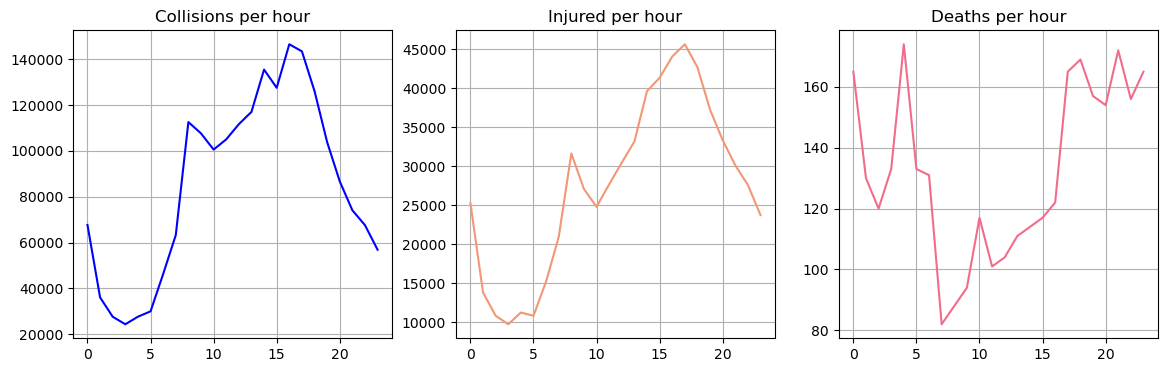

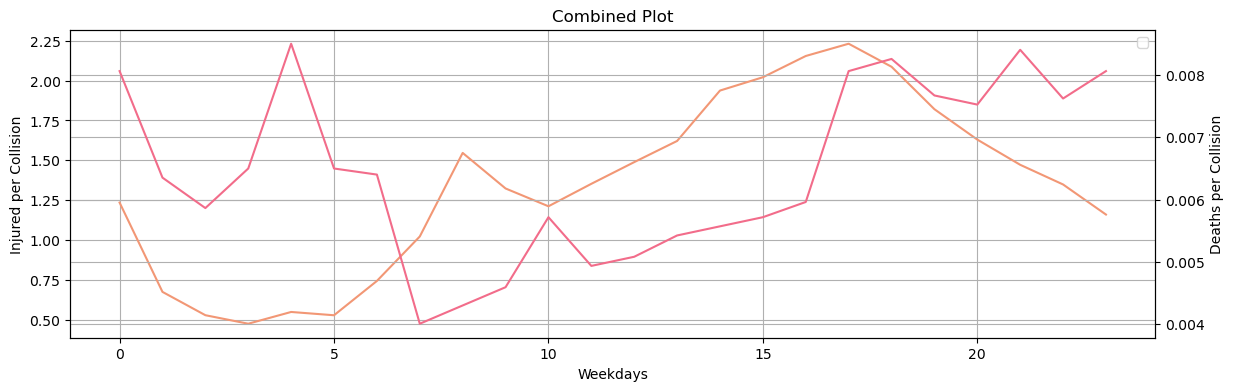

In [8]:
hours_list=list(range(0,25))
viz_per_time_period(crashes, 'hour', hours_list)

> Once again, the number of collisions and the number of injured people move together but not the total deaths which follow a different pattern: a valley during the day and high numbers early and late in the day.

> The viz by collision shows the same: the number of people injured by collision starts declining during afternoon, while the ratio of deaths by collision keeps climbing until early morning.

<a id="weekend"></a>

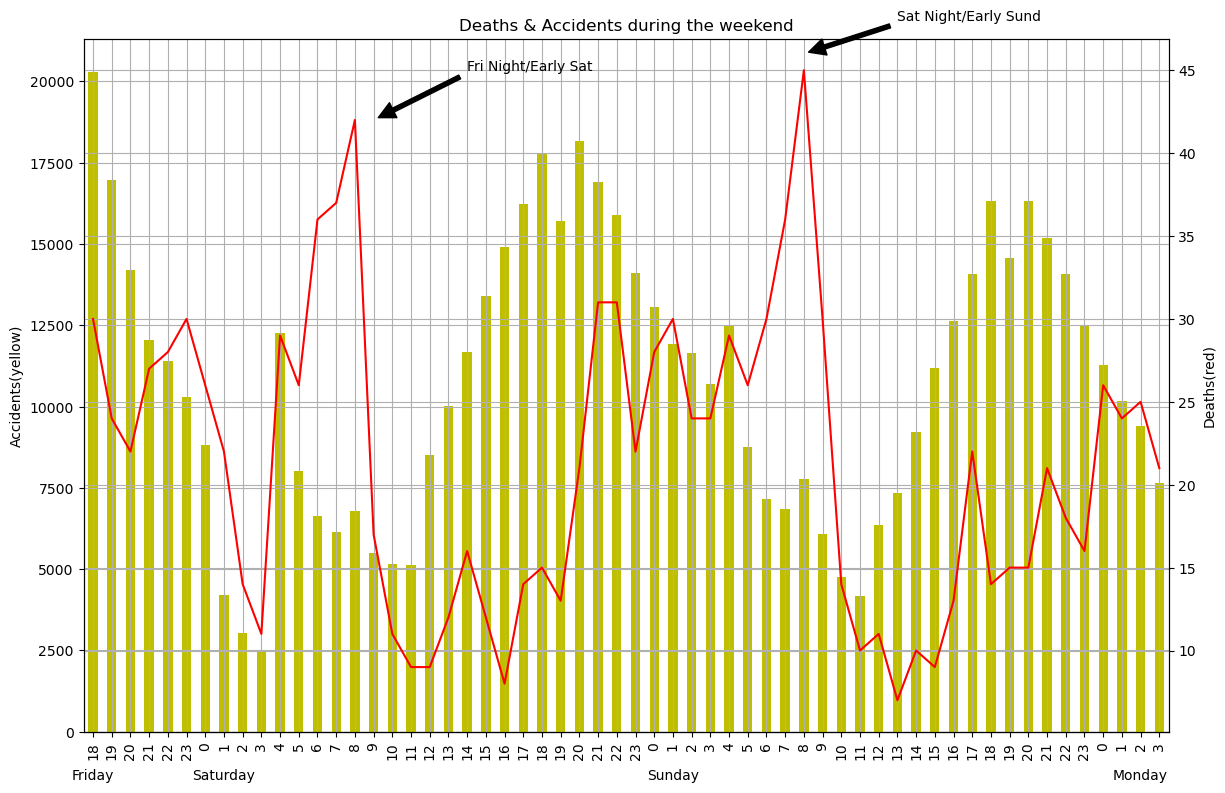

In [128]:
acc_weekend=crashes.groupby(['weekday','hour']).agg({'collision_id':'count',
                             'number_of_persons_injured':'sum',
                             'number_of_persons_killed':'sum'
                             })

acc_weekend.columns=['num_accidents','num_victims','num_deaths']
acc_weekend.drop(['Tue','Wed', 'Thu'],inplace=True)
friday_hours_to_drop=[('Fri',hour) for hour in range(0,18)]
monday_hours_to_drop=[('Mon',hour)for hour in range(4,24)]
to_drop=friday_hours_to_drop+monday_hours_to_drop
acc_weekend.drop(to_drop,inplace=True)
fri_hours,sat_hours,sun_hours,mon_hours=[],[],[],[]
[fri_hours.append(idx) if idx[0]=='Fri'
                        else sat_hours.append(idx) if idx[0]=='Sat'
                        else sun_hours.append(idx) if idx[0]=='Sun'
                         else mon_hours.append(idx) for idx in acc_weekend.index]
new_index=fri_hours+sat_hours+sun_hours+mon_hours
acc_weekend.index=new_index

first_level_ticks=[x[1] for x in acc_weekend.index]


fig = plt.figure(figsize=(14, 9)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4
acc_weekend.plot(kind='bar', y='num_accidents', color='y', ax=ax, legend=False )#.legend(loc='best')
acc_weekend.plot(kind='line', y='num_deaths', color='r', ax=ax2, legend=False)#.legend(loc='best')
#ax.set_xticks(first_level_ticks)
ax.set_ylabel('Accidents(yellow)')
ax2.set_ylabel('Deaths(red)')
#ax.set_xticklabels(first_level_ticks, rotation= 360)
#ax.set_xticks()
#ax.set_yticklabels(yticks)
plt.annotate('Fri Night/Early Sat', xy=(15, 42), xytext=(20, 45),
            arrowprops=dict(facecolor='black', shrink=0.05, width=3),
            )
plt.annotate('Sat Night/Early Sund', xy=(38, 46), xytext=(43, 48),
            arrowprops=dict(facecolor='black', shrink=0.05, width=3),
            )
#plt.xticks(ticks=[0, 2, 3, 4, 5], labels=['FriDAY', 'B', 'C', 'D', 'E'])
plt.xticks(list(range(58)),first_level_ticks)
# label the days:
sec = ax.secondary_xaxis(location=0)
sec.set_xticks([0, 7, 31,56], labels=['\n\nFriday', '\n\nSaturday', '\n\nSunday','\n\nMonday'])
sec.tick_params('x', length=0)
plt.title('Deaths & Accidents during the weekend');

> Interestingly, the variation of the number of collisions and the number of deaths move together except for the early hours on Saturday and Sunday.

> The viz of collisions and number of victims does not afford relevant information as they move together during the period.

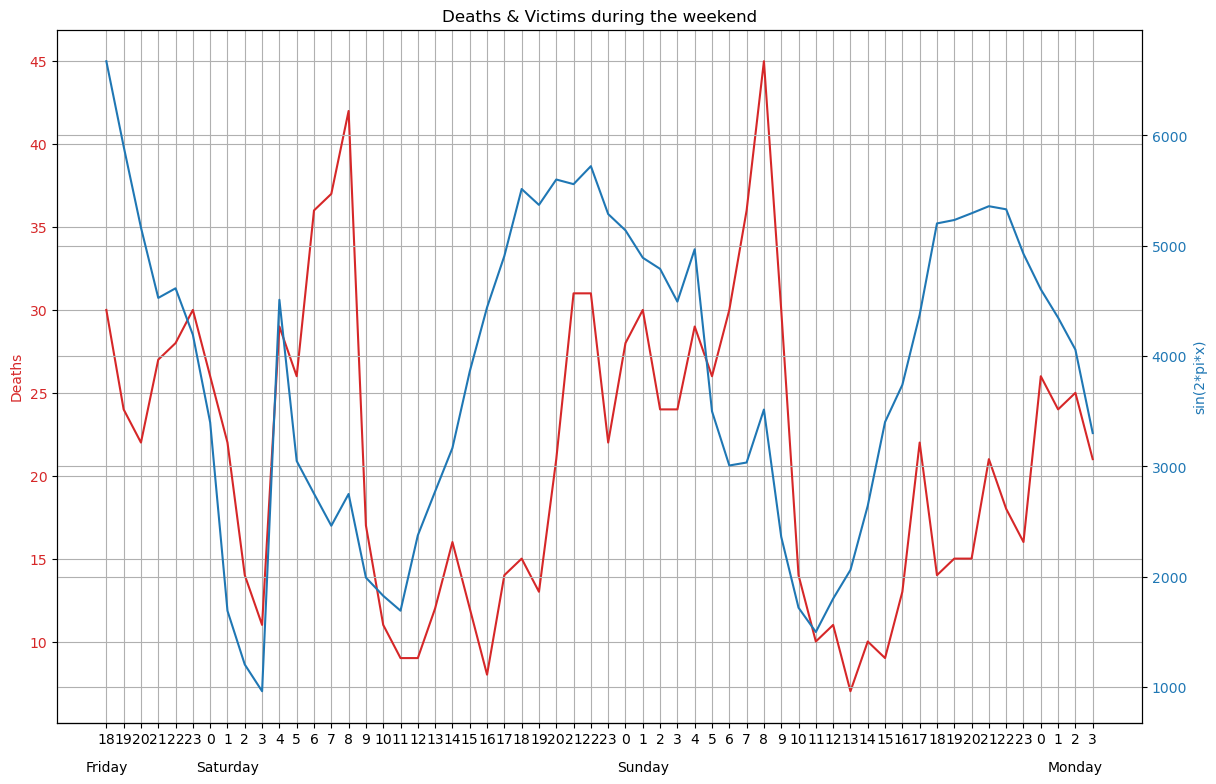

In [147]:

# Sample data
x = range(58)
y1 = acc_weekend.num_deaths
y2 = acc_weekend.num_victims

# Create the figure and the first axes

fig, ax1 = plt.subplots()

# Plot the first line on the first axes
color = 'tab:red'

ax1.set_ylabel('Deaths', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axes sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second line on the second axes
color = 'tab:blue'
ax2.set_ylabel('sin(2*pi*x)', color=color)
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(list(range(58)),first_level_ticks)
# label the days:
sec = ax1.secondary_xaxis(location=0)
sec.set_xticks([0, 7, 31,56], labels=['\n\nFriday', '\n\nSaturday', '\n\nSunday','\n\nMonday'])
sec.tick_params('both', length=0)
plt.title('Deaths & Victims during the weekend');
#Display the plot
fig.set_size_inches(14,9)
plt.show();

[return to top](#top)